# Proximity Forest: Smaller epitope

Up to now, I've used a proximity forst on the Influenza A epitope. However,there are quite a lot of samples from that epitope, which causes the proximity forest (PF) implementation to  take quite a lot of time. This prevents us from experimenting whith parameters for improving the algorithm (mainly the samples to split), so let's try an epitope with less samples.

In the notebook "Different epitopes", we took a look at the other epitopes in the vdjdb dataset and filtered the usable ones out of it. Let's start with ignoring the NaN problem and select a complete epitope.

In [16]:
import numpy as np
import pandas as pd
from tcrdist.repertoire import TCRrep
from util import get_train_dataset, ProximityTreeClassifier, calculate_tcr_dist_multiple_chains
from sklearn.model_selection import train_test_split
from util import ProximityForestClassifier, calculate_tcr_dist2, calculate_tcr_dist2_cached
from sklearn.metrics import accuracy_score
from sklearn import metrics
from util import plot_roc_curve, get_epitope_df, evaluate, get_features, fix_test, calculate_tcr_dist2_cached
from sklearn.ensemble import RandomForestClassifier


In [17]:
df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')

rename_columns = {
    'antigen.epitope': 'epitope',
    'cdr3.alpha': 'CDR3_alfa',
    'v.alpha': 'TRAV',
    'j.alpha': 'TRAJ',
    'cdr3.beta': 'CDR3_beta',
    'v.beta': 'TRBV',
    'j.beta': 'TRBJ',
}

df_vdjdb = df_vdjdb.rename(columns=rename_columns)
df_vdjdb = df_vdjdb[rename_columns.values()]
df_vdjdb.head()

C:\Users\arnod\AppData\Local\Temp/ipykernel_24992/1551846585.py:1: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


,epitope,CDR3_alfa,TRAV,TRAJ,CDR3_beta,TRBV,TRBJ
0,FLKEKGGL,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01
1,FLKEKGGL,NaN,NaN,NaN,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01
2,FLKEKGGL,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01
3,FLKEKGGL,CAVKASGSRLT,TRAV2*01,NaN,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01
4,FLKEKGGL,CAYRPPGTYKYIF,TRAV38-2/DV8*01,TRAJ40*01,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01


In [18]:
# get all "epitope" names that have "CDR3_alfa" or "CDR3_beta" as NaN
nan_epitopes = df_vdjdb[df_vdjdb['CDR3_alfa'].isna() | df_vdjdb['CDR3_beta'].isna()]['epitope'].unique()
print(f"There are {len(nan_epitopes)} epitopes with NaN values in the CDR3_alfa or CDR3_beta columns")
# drop all rows that have an "epitope" name that is in "nan_epitopes"
df_vdjdb = df_vdjdb[~df_vdjdb['epitope'].isin(nan_epitopes)]
# print  the counts of the remaining epitopes
print(df_vdjdb['epitope'].value_counts())

There are 518 epitopes with NaN values in the CDR3_alfa or CDR3_beta columns
KLGGALQAK     13974
SSYRRPVGI       661
SSLENFRAYV      437
RLRAEAQVK       431
ASNENMETM       325
              ...  
TLEYMDWLV         1
WLDNFELCL         1
KLEFMDWRL         1
RMEQVDWTV         1
YYTSNPTTF         1
Name: epitope, Length: 632, dtype: int64


In [19]:
# print the counts of those epitopes that have 100-200 samples, don't print the others
print(df_vdjdb['epitope'].value_counts().loc[lambda x: x.between(100, 200)])

LSLRNPILV    155
LTDEMIAQY    135
Name: epitope, dtype: int64


## Evaluate

In [20]:
current_epitope = 'LSLRNPILV'

In [21]:
# mouse_df = get_epitope_df(current_epitope, species='MusMusculus')
# human_df = get_epitope_df(current_epitope, species='HomoSapiens')
# print(f"There are {len(mouse_df)} mouse samples and {len(human_df)} human samples for the epitope {current_epitope}")

In [22]:
epitope_df = get_epitope_df(current_epitope, species='MusMusculus')
# epitope_df = epitope_df.sample(100) # TODO: remove
print(f"Created a dataframe with {len(epitope_df)} samples for the epitope {current_epitope}")

Number of negative samples changed from 2918 to 2870 (because of overlap with positive samples)
Positive samples: alpha only: 0, beta only: 0, both: 155, none: 0
Negative samples: alpha only: 69, beta only: 753, both: 2048, none: 0
Created a dataframe with 310 samples for the epitope LSLRNPILV


C:\Users\arnod\PycharmProjects\thesis\util\epitopes.py:6: DtypeWarning: Columns (20,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vdjdb = pd.read_csv('data/vdjdb-2022-03-30/vdjdb_full.txt', sep='\t')


In [23]:
y_column = 'reaction'
x_columns = ['CDR3_alfa', 'TRAV', 'TRAJ', 'CDR3_beta', 'TRBV', 'TRBJ']
epitope_df = epitope_df[x_columns + [y_column]]
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42) # not using this, no nan -> KFold

epitope_x = epitope_df[x_columns]
epitope_y = epitope_df[y_column]

In [24]:
y = epitope_y
x_features = get_features(epitope_x)
# features introduce NaN values, set them to 0
x_features = np.nan_to_num(x_features, nan=0)

### RandomForest

In [25]:
# check the performance on a RandomForest classifier
clf = RandomForestClassifier(n_estimators=100)
evaluate(clf, x_features, y)

[0.9037461  0.89791667 0.93809524 0.92737722 0.91770833]
ROC: 0.917 (+/- 0.030)


# Proximity Forest

In [26]:
# # np_x = epitope_x.to_numpy()
# # np_y = epitope_y.to_numpy()
#
# np_x = epitope_x
# np_y = epitope_y
#
# model = ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist2_cached,
#                                   distance_kwargs={"nan_distance": 0, 'organism': "mouse"}, multithreaded=False)
#
# evaluate(clf, np_x, np_y)

In [27]:
np_x = epitope_x
np_y = epitope_y

Predicting: 100%|██████████| 100/100 [32:01<00:00, 19.22s/it] 


0.8225806451612904


Predicting: 100%|██████████| 100/100 [00:01<00:00, 55.55it/s]


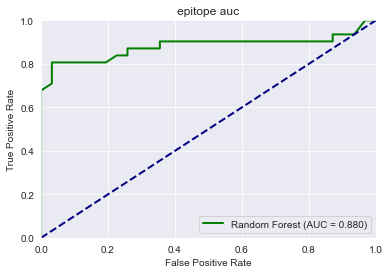

ROC AUC: 0.8803329864724245


Predicting: 100%|██████████| 100/100 [04:08<00:00,  2.48s/it]


0.7741935483870968


Predicting: 100%|██████████| 100/100 [00:01<00:00, 64.52it/s]


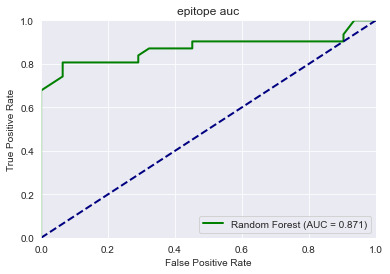

ROC AUC: 0.8714880332986472


In [28]:
model = ProximityForestClassifier(reduce_features=False, distance_measure=calculate_tcr_dist2_cached,
                                  distance_kwargs={"nan_distance": 0, 'organism': "mouse"}, multithreaded=False)


# split np_x8 and np_y into train and test
train_X, val_X, train_y, val_y = train_test_split(np_x, np_y, test_size=0.2, random_state=42)

model.fit(train_X, train_y)


predictions = model.predict(val_X)

print(accuracy_score(val_y, predictions))

predictions = model.predict_proba(val_X)
fpr, tpr, thresholds = metrics.roc_curve(val_y, predictions[:, 1], pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
plot_roc_curve(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.3f})', title="epitope auc")
print(f"ROC AUC: {roc_auc}")

checken hoe groot bomen zijn
wrs aantal samples, kfold toegepast
ceder heeft sklearn code om te plotten

In [29]:
def get_auc(clf, np_x, np_y, seed):
    train_X, val_X, train_y, val_y = train_test_split(np_x, np_y, test_size=0.2, random_state=seed)

    clf.fit(train_X, train_y)

    # predictions = clf.predict(val_X)
    # print(accuracy_score(val_y, predictions))

    predictions = model.predict_proba(val_X)
    fpr, tpr, thresholds = metrics.roc_curve(val_y, predictions[:, 1], pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc}")
    return roc_auc

In [30]:
aucs = []
for i in range(5):
    aucs.append(get_auc(model, np_x, np_y, i))

Predicting: 100%|██████████| 200/200 [12:05<00:00,  3.63s/it]


ROC AUC: 0.8354166666666667


Predicting: 100%|██████████| 300/300 [08:33<00:00,  1.71s/it]


ROC AUC: 0.9114583333333333


Predicting: 100%|██████████| 400/400 [04:50<00:00,  1.38it/s]


ROC AUC: 0.791363163371488


Predicting: 100%|██████████| 500/500 [02:34<00:00,  3.23it/s]


ROC AUC: 0.931321540062435


Predicting: 100%|██████████| 600/600 [01:30<00:00,  6.66it/s]

ROC AUC: 0.9322916666666666


In [33]:
print(aucs)
print(f"ROC: {np.mean(aucs):.3f} (+/- {np.std(aucs) * 2:.3f})")

[0.8354166666666667, 0.9114583333333333, 0.791363163371488, 0.931321540062435, 0.9322916666666666]
ROC: 0.880 (+/- 0.114)


### Vary the parameters

I'm now mainly interested in changing samples_to_use to the entire dataset and enable subsampling on each tree of the random forest.

nederlandstalig: esp instructies
verdediging eind juni:
2 weken voor indienen versie doorsturen, midden mei eerste draft

Week van de 12e best submiten, uiterlijk de 16e.
Half mei best al een eerste draft doorsturen. (moet nog niet volledig afzijn, delen kunnen ontbreken)